In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sensordata
sns.set_style(style='whitegrid')

datasets, features_sets, target_sets, metadata = sensordata.load_and_preprocess_data(validationset=True, savecsv=False, sensorset='FIS')
calibrationset = datasets[0]
calibration_features_matrix = features_sets[0]
calibration_co_cons = target_sets[0]
cal_experiment_matrix, cal_targets = sensordata.postprocess_data(calibration_features_matrix, calibration_co_cons)

/home/dreuter/Github/kaggle-paths/gas-sensor-array/data/gas-sensor-data.zip
already exists, file not downloaded
csv files already exists in
/home/dreuter/Github/kaggle-paths/gas-sensor-array/data,
no files extracted
Starting to import and preprocess sensor data from 20160930_203718.csv
The shape of features matrix is:
(2020, 378)
20160930_203718.csv successfully imported
Starting to import and preprocess sensor data from 20161001_231809.csv
The shape of features matrix is:
(2016, 378)
20161001_231809.csv successfully imported
Starting to import and preprocess sensor data from 20161003_085624.csv
The shape of features matrix is:
(2020, 378)
20161003_085624.csv successfully imported
Starting to import and preprocess sensor data from 20161004_104124.csv
The shape of features matrix is:
(2020, 378)
20161004_104124.csv successfully imported
Starting to import and preprocess sensor data from 20161005_140846.csv
The shape of features matrix is:
(2016, 378)
20161005_140846.csv successfully imp

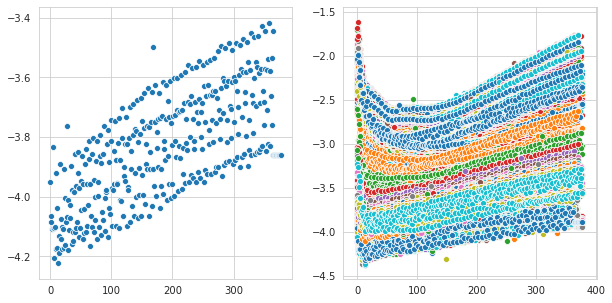

In [29]:
day = 1
fig, axes = plt.subplots(1,2, figsize=(10,5))
signalsample = 1
signalconc = target_sets[day-1][signalsample]
signal = features_sets[day-1][signalsample,:]
nsig = len(signal)
sns.scatterplot(np.arange(nsig),signal, ax=axes[0])

signalconcs = target_sets[day-1]
signals = features_sets[day-1]
nsig = len(signals)
for signal in signals[:100]:
    nsig = len(signal)
    sns.scatterplot(np.arange(nsig),signal, ax=axes[1])
plt.show()

In [30]:
obs = 0
dim = features_sets[0].shape[1]
for set in features_sets:
    obs+=set.shape[0]
features = np.zeros((obs,dim))
target = np.zeros((obs,1))
i = 0
end_obs = 0

for set in range(len(features_sets)):
    start_obs = end_obs
    end_obs += features_sets[set].shape[0]
    features[start_obs:end_obs,:] = features_sets[set]
    target[start_obs:end_obs,:] = target_sets[set]

target = target.reshape(len(target))

features = np.array(pd.DataFrame(features).interpolate(axis=1))
features = np.array(pd.DataFrame(features).interpolate(axis=0))
print(features.shape)
print(target.shape)

data = target
test_ratio = 0.2
shuffled_indices = np.random.permutation(len(data))
test_set_size = int(len(data) * test_ratio)
test_indices = shuffled_indices[:test_set_size]
train_indices = shuffled_indices[test_set_size:]

X_train = features[train_indices]
X_test = features[test_indices]
y_train = target[train_indices]
y_test = target[test_indices]

(26240, 378)
(26240,)


In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X_train)

print(np.sum(pca.explained_variance_ratio_))

0.9884382682839792


In [37]:
print(X_train.shape)
print(X2D.shape)

(20992, 378)
(20992, 2)


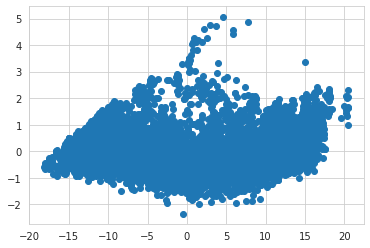

In [38]:
plt.scatter(X2D[:,0],X2D[:,1])
plt.show()

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

estimator_range = np.arange(10, 21)
rmse = []
for i in estimator_range:
    forest_reg = RandomForestRegressor(n_estimators=i, n_jobs=-1)
    score = cross_val_score(forest_reg, X2D, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    print("Estimators " + str(i) + " score: " + str(np.sqrt(-score)))
    rmse.append(np.sqrt(-score))

Estimators 10 score: 2.744686185070203
Estimators 11 score: 2.7286724503060653
Estimators 12 score: 2.714800555323081
Estimators 13 score: 2.704434146497776
Estimators 14 score: 2.7049560053905366
Estimators 15 score: 2.6970256726119515
Estimators 16 score: 2.699927607285018
Estimators 17 score: 2.6764293974356907
Estimators 18 score: 2.694846697160302
Estimators 19 score: 2.6854438522105366
Estimators 20 score: 2.694364834016663


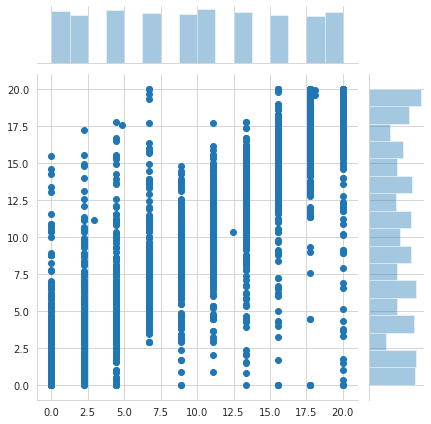

In [47]:
forest_reg.fit(X2D, y_train)

X2D_test = pca.transform(X_test)

predictions = forest_reg.predict(X2D_test)

sns.jointplot(y_test, predictions)
plt.show()

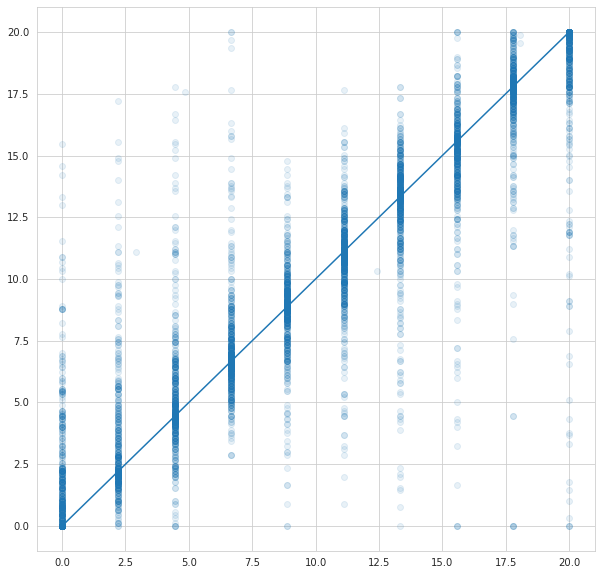

In [48]:
x = y_test
y = predictions.reshape(len(predictions))
plt.figure(figsize=(10,10))
plt.scatter(x,y,alpha=0.1)
plt.plot(np.arange(0,21),np.arange(0,21))
plt.show()